In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

  Running setup.py bdist_wheel for sklearn ... - \ done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.models import Model
from keras.layers import *
from keras.layers.merge import concatenate

In [0]:
file_import = drive.CreateFile({'id':'15j1Nou6m5WNLejJQrUcty6U03xsIgIAI'})
file_import.GetContentFile('SelfAttention.py') 

from SelfAttention import SelfAttention

In [0]:
def one_by_one(filtersNumber, inputLayer, dropout = 0.2):
    one_by_one = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    one_by_one = BatchNormalization()(one_by_one)
    one_by_one = SpatialDropout1D(dropout)(one_by_one)
    
    return one_by_one

In [0]:
def yoon_kim_feature_extractor(filtersNumber, inputLayer):
    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    block_1_features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    block_1_features = Dropout(0.2)(block_1_features)
    return block_1_features

In [0]:
def single_category_regressor(features, context, context2, unitsNumber = 64):
    features = concatenate([features, context])
    
    dense_1 = Dense(unitsNumber, activation = 'elu')(features)
    dense_1_normalization = BatchNormalization()(dense_1)
    dense_1_dropout = Dropout(0.2)(dense_1_normalization)

    features = concatenate([dense_1_dropout, context2])

    dense_2 = Dense(unitsNumber, activation = 'elu')(features)
    dense_2_normalization = BatchNormalization()(dense_2)
    dense_2_dropout = Dropout(0.2)(dense_2_normalization)
    
    return Dense(1, activation='sigmoid')(dense_2_dropout)

In [12]:
maxWords = 30000
maxSequenceLengthInWords = 400
embeddingDimension = 300
filtersNumber = 300

input_layer = Input(shape=(maxSequenceLengthInWords,))

pretrained_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

embedding = Average()([pretrained_embedding_layer, custom_embedding_layer])
embedding_dropout = SpatialDropout1D(0.2)(embedding)

embedding_dropout = SelfAttention()(embedding_dropout)

features_1 = one_by_one(filtersNumber, embedding_dropout)
features_2 = one_by_one(filtersNumber, features_1)
features_3 = one_by_one(filtersNumber, features_2)

features = yoon_kim_feature_extractor(filtersNumber, features_3)


dense_1 = Dense(256, activation = 'elu')(features)
dense_1_normalization = BatchNormalization()(dense_1)
dense_1_dropout = Dropout(0.2)(dense_1_normalization)

dense_2 = Dense(256, activation = 'elu')(dense_1_dropout)
dense_2_normalization = BatchNormalization()(dense_2)
dense_2_dropout = Dropout(0.2)(dense_2_normalization)

output_layer = Dense(6, activation='sigmoid')(dense_2_dropout)

single_category_layer = concatenate([
    single_category_regressor(features, dense_1_dropout, dense_2_dropout, 64),
    single_category_regressor(features, dense_1_dropout, dense_2_dropout, 64),
    single_category_regressor(features, dense_1_dropout, dense_2_dropout, 64),
    single_category_regressor(features, dense_1_dropout, dense_2_dropout, 64),
    single_category_regressor(features, dense_1_dropout, dense_2_dropout, 64),
    single_category_regressor(features, dense_1_dropout, dense_2_dropout, 64),
])

output_layer = add([output_layer, single_category_layer])

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [17]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
102124/102124 [==============================] - 656s 6ms/step - loss: 1.3984 - acc: 0.8168 - val_loss: 0.1642 - val_acc: 0.9617....] - ETA: 3:43 - loss: 1.9749 - acc: 0.7472102112/102124 [============================>.] - ETA: 0s - loss: 1.3986 - acc: 0.816
Epoch 2/32
 10144/102124 [=>............................] - ETA: 9:07 - loss: 0.1965 - acc: 0.9540 46752/102124 [============>.................] - ETA: 5:28 - loss: 0.1599 - acc: 0.9589 84608/102124 [=======================>......] - ETA: 1:43 - loss: 0.1349 - acc: 0.9639102124/102124 [==============================] - 646s 6ms/step - loss: 0.1273 - acc: 0.9654 - val_loss: 0.0688 - val_acc: 0.9767
roc-auc: 0.9532 - roc-auc_val: 0.9532                                                                                                    
Epoch 3/32
  4480/102124 [>.............................] - ETA: 9:39 - loss: 0.1022 - acc: 0.9675 54400/102124 [==============>............

  7520/102124 [=>............................] - ETA: 9:21 - loss: 0.0407 - acc: 0.9841 69408/102124 [===================>..........] - ETA: 3:13 - loss: 0.0398 - acc: 0.9843102124/102124 [==============================] - 644s 6ms/step - loss: 0.0401 - acc: 0.9842 - val_loss: 0.0415 - val_acc: 0.9843
Epoch 20/32
  1472/102124 [..............................] - ETA: 9:51 - loss: 0.0402 - acc: 0.9851 43072/102124 [===========>..................] - ETA: 5:48 - loss: 0.0401 - acc: 0.9841 95616/102124 [===========================>..] - ETA: 38s - loss: 0.0400 - acc: 0.9841102124/102124 [==============================] - 643s 6ms/step - loss: 0.0402 - acc: 0.9841 - val_loss: 0.0404 - val_acc: 0.9844
roc-auc: 0.9935 - roc-auc_val: 0.9876                                                                                                    
Epoch 21/32
  7104/102124 [=>............................] - ETA: 9:19 - loss: 0.0393 - acc: 0.9851 46944/102124 [============>.................] - ETA: 5:25 

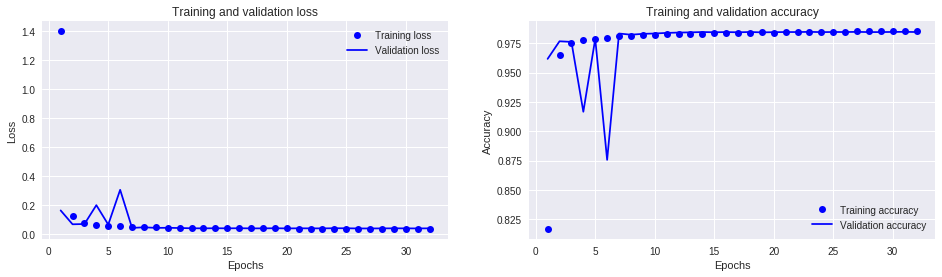

In [18]:
plot_history(history)

In [19]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 55s 2ms/step
([0.038740241001884654, 0.9850174801468793], 0.9884953185588751)


In [13]:
history = train_with_cv(model, batchSize=64, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 42816/102124 [===========>..................] - ETA: 5:22 - loss: 4.6695 - acc: 0.5038102124/102124 [==============================] - 581s 6ms/step - loss: 2.6057 - acc: 0.6692 - val_loss: 0.9295 - val_acc: 0.9125
Epoch 2/32
  5376/102124 [>.............................] - ETA: 8:18 - loss: 0.5109 - acc: 0.9023102080/102124 [============================>.] - ETA: 0s - loss: 0.3335 - acc: 0.9378102124/102124 [==============================] - 569s 6ms/step - loss: 0.3334 - acc: 0.9378 - val_loss: 0.1780 - val_acc: 0.9645
roc-auc: 0.7192 - roc-auc_val: 0.7224                                                                                                    
Epoch 3/32
102124/102124 [==============================] - 568s 6ms/step - loss: 0.1546 - acc: 0.9638 - val_loss: 0.0968 - val_acc: 0.9770==>.] - ETA: 0s - loss: 0.1546 - acc: 0.963
Epoch 4/32
 20352/102124 [====>.........................] - ETA: 7:06 - loss: 0.1201 - ac

102124/102124 [==============================] - 565s 6ms/step - loss: 0.0390 - acc: 0.9845 - val_loss: 0.0411 - val_acc: 0.9844==>.] - ETA: 0s - loss: 0.0390 - acc: 0.984
Epoch 28/32
 20288/102124 [====>.........................] - ETA: 6:59 - loss: 0.0376 - acc: 0.9854102080/102124 [============================>.] - ETA: 0s - loss: 0.0387 - acc: 0.9847102124/102124 [==============================] - 567s 6ms/step - loss: 0.0387 - acc: 0.9847 - val_loss: 0.0419 - val_acc: 0.9841
roc-auc: 0.994 - roc-auc_val: 0.9875                                                                                                    
Epoch 29/32
102124/102124 [==============================] - 561s 5ms/step - loss: 0.0385 - acc: 0.9846 - val_loss: 0.0408 - val_acc: 0.9846==>.] - ETA: 0s - loss: 0.0385 - acc: 0.984
Epoch 30/32
 20288/102124 [====>.........................] - ETA: 6:58 - loss: 0.0387 - acc: 0.9845102080/102124 [============================>.] - ETA: 0s - loss: 0.0381 - acc: 0.9849102124/102

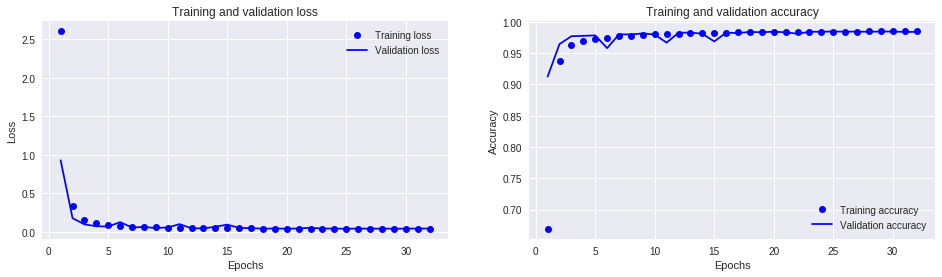

In [14]:
plot_history(history)

In [15]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 56s 2ms/step
([0.0406538087058157, 0.9842550383435136], 0.9894485128841984)
